# Notebook for social neural population decoding (NPD)
With inspiration from:
"The geometry of hippocampal CA2 representations enables abstract coding of social familiarity and identity" - Boyle 2022

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import expipe
import sys
import pathlib
import numpy as np
import numpy.ma as ma
import scipy
import tqdm
import pandas as pd

from scipy.interpolate import interp1d

sys.path.append('../ca2-mec') if '../ca2-mec' not in sys.path else None 
import data_processing as dp

In [3]:
# change matplotlib default figsize and fonts
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize') or
        k.endswith('titlesize')
    )
})

In [4]:
# get actions
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions
# actions
list(actions.keys())


['002-050721-3',
 '002-050721-2',
 '001-280721-3',
 '145-141021-2',
 '011-120321-5-sarah',
 '002-050721-1',
 '145-141021-4',
 '011-120321-2-sarah',
 '001-280721-5',
 '145-141021-5',
 '137-230121-6',
 '001-280721-1',
 '137-230121-3',
 '001-290721-2',
 '145-141021-3',
 '145-141021-6',
 '011-120321-3-sarah',
 '002-050721-5',
 '011-120321-6-sarah',
 '001-290721-1',
 '011-280721-2',
 '002-050721-4',
 '011-280721-1',
 '001-290721-3',
 'identify-neurons',
 '011-120321-4-sarah',
 '001-280721-4',
 '137-230121-5',
 '137-230121-2',
 '145-141021-1',
 '001-280721-2',
 '137-230121-4']

### Initialise data loader

In [5]:
# remove leading and trailing recording data
t_start = 0
t_stop = None # None => don't remove anything

max_speed = 1 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size=0.02
smoothing = 0.05

data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, stim_mask=False, baseline_duration=None,
)

### Load data (tracking and spikes), and use unique unit IDs

In [6]:
identify_neurons = project.require_action('identify-neurons')
identify_neurons = pd.read_csv(identify_neurons.data_path() / "units.csv")
identify_neurons.head()

,unit_name,unit_idnum,unit_id,action,channel_group,max_dissimilarity,max_depth_delta
0,1,0,4b00d7e4-124b-410d-a27c-0bbe057547e7,011-280721-1,0,0.05,100
1,5,1,19254312-eea2-4909-874b-8f46cc1f2b81,011-280721-1,0,0.05,100
2,6,2,eb764c9f-1b7d-4105-acac-a5c91f060e8a,011-280721-1,0,0.05,100
3,10,3,4b068856-ebdb-4eeb-8149-c3328ac4d1de,011-280721-1,1,0.05,100
4,6,3,4b068856-ebdb-4eeb-8149-c3328ac4d1de,011-280721-2,1,0.05,100


In [7]:
# select actions to include
actions = ['011-280721-1', '011-280721-2']

# load all tracking data (dict)trial x (dict)track_quantities x (array)time
tracking = [(action_id, data_loader.tracking(action_id)) for action_id in actions]
tracking = {action_id:track for action_id, track in tracking}

# load all spikes data (dict)trial x (dict)unit_id x spike_train
# and use identify-neurons to assign unique IDs to each unit
spikes = {}
for action_id in tqdm.tqdm(actions):
    spikes[action_id] = {}
    channel_grps = dp.get_channel_groups(data_loader.data_path(action_id))
    action_mask = identify_neurons['action'] == action_id
    for channel_grp in channel_grps:
        spike_train = data_loader.spike_trains(action_id, channel_grp)
        for unit_id in spike_train:
            unique_unit_id_idx = (identify_neurons['unit_name'] == unit_id) & action_mask
            unique_unit_id = identify_neurons['unit_id'][unique_unit_id_idx].item()
            spikes[action_id][unique_unit_id] = spike_train[unit_id]
        # load units and "flatten" channel_grps dimension. - assuming units are unique OR duplicates across channels
        #spikes[action_id].update(data_loader.spike_trains(action_id, channel_grp))

100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


### Transform coordinates to align with physical perception

In [8]:
def transform_coordinates(x, y, theta=90, **kwargs):
    """
    Transform tracking coordinates to align with physical coordinates
    For this project (CA2 MEC): rotate recorded coordinates 90 degrees, 
    followed by a shift to make values positive afterwards.
    """
    # rotate x,y coordinates 90 degrees using a 2D rotation matrix transform
    theta = np.radians(theta)
    r = np.array(( (np.cos(theta), -np.sin(theta)),
                   (np.sin(theta),  np.cos(theta)) ))
    coords = r @ np.array([x,y])
    # shift new x-coordinates to be positive
    coords -= np.array([[-1],[0]])
    return coords

import copy
transformed_tracking = copy.deepcopy(tracking)
for trial in tracking:
    newx, newy = transform_coordinates(**tracking[trial])
    transformed_tracking[trial]['x'] = newx
    transformed_tracking[trial]['y'] = newy

### Define social masks (closeness to transparent boxes)

In [9]:
def corner_masks(x, y, margin=0.4, **kwargs):
    """
    Find corner and center of box masks.
    """
    assert margin < 0.5 and margin > 0, "OBS! Margin must be positive and max half the box size, i.e. 0.5 OBS!"
    
    # center x and y coordinates
    x = x - 0.5
    y = y - 0.5
    pos = np.array([x, y]).T
    
    # create cardinal basis vectors
    ex, ey = np.arange(2), np.arange(2)[::-1]
    
    # create corner vectors: TR, TL, BL and BR, respectively
    corners = np.array([ex+ey, -ex+ey, -ex-ey, ex-ey])
    
    corner_masks = np.zeros((len(x), 5),dtype=bool)
    for i, corner in enumerate(corners):
        # find which quadrant positions are in, and if they are within the
        # box margins. The intersection gives the grand mask.
        quadrant_mask = ((pos * corner) > 0).all(axis=-1)
        margin_mask = (np.abs(pos) > (np.ones(2) * (0.5 - margin))).all(axis=-1)
        corner_masks[:,i] = quadrant_mask & margin_mask
    
    # inverse of union over corner masks
    corner_masks[:,-1] = ~np.array(corner_masks).any(axis=-1)
    return corner_masks

for trial in tracking:
    transformed_tracking[trial]['cms'] = corner_masks(**transformed_tracking[trial])

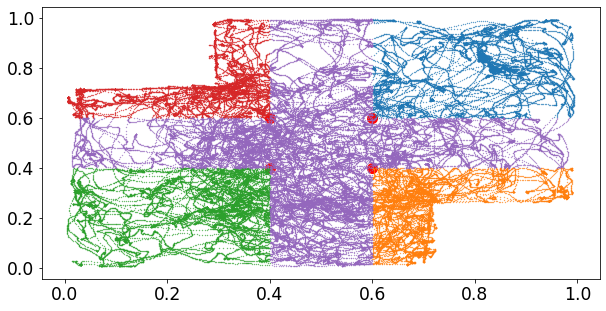

In [10]:
# inspect spatial (corner) masking
plt.figure(figsize=(10,5))
#plt.plot(tracking['011-280721-1']['x'], tracking['011-280721-1']['y'])
margin = 0.40
BL=(0+margin,0+margin)
TL=(0+margin,1-margin)
TR=(1-margin,1-margin)
BR=(1-margin,0+margin)
plt.scatter(*BL, color = 'red', s=100)
plt.scatter(*TL, color = 'red', s=100)
plt.scatter(*TR, color = 'red', s=100)
plt.scatter(*BR, color = 'red', s=100)

pos = np.array([tracking['011-280721-1']['x'], tracking['011-280721-1']['y']]).T
cms = corner_masks(*pos.T)
for cm in cms.T:
    plt.scatter(*pos[cm].T, s=0.1)

### Truncate recordings

In [11]:
def truncate_recording(arr, t, t_start=0.0, t_stop=None):
    """
    Truncate recording, in seconds.
    if t_start or t_stop is None, then don't truncate
    """
    if not isinstance(arr, np.ndarray):
        return arr
    mask = np.ones(len(arr),dtype=bool)
    mask = (t > t_start) if t_start is not None else mask
    mask = mask & (t < t_stop) if t_stop is not None else mask
    return arr[mask]

t_start, t_stop = 0, 1200
for trial in tracking:
    for quantity_name, quantity in transformed_tracking[trial].items():
        transformed_tracking[trial][quantity_name] = truncate_recording(quantity, tracking[trial]['t'], t_start = t_start, t_stop = t_stop)

### Select units that appear in all trials

In [12]:
def persistent_units(spikes):
    """
    Find all units that persist across all trials for each animal (cumulative intersection over trials)
    """
    punits = []
    for trial in spikes:
        if not punits:
            # empty list
            punits = list(spikes[trial].keys())
            continue
        punits = list(spikes[trial].keys() & punits)
    return punits

punits = persistent_units(spikes)
punits

['c1d916cd-d0b5-4553-be9b-bf82f03be95e',
 '4b068856-ebdb-4eeb-8149-c3328ac4d1de',
 '93f98713-731e-4933-8c66-0b58dcb590d4',
 '0f6c0c29-fee6-46ce-bd2e-4c09962dec2f',
 'eed81f30-e655-4039-81fd-42dc6131d664']

In [13]:
def social_label(action_str):
    """
    socializing can happen at either of the four corners of the box (space).
    there are four types of socializing: nobox (-1) empty (0), familiar (1) or novel (2).
    this gives a 4d-vector with four possible categories each.
    """
    
    def social_category(str1, str2):
        """ helper function """
        if str1 == 'nobox':
            return -1
        if str2 == 'e':
            return 0
        if str2 == 'f':
            return 1
        if str2 == 'n':
            return 2
    
    tags = project.require_action(action_str).attributes['tags']
    social_types = {'s': np.zeros(4), 'o': np.zeros(4)}
    for tag in tags:
        if not 'corner' in tag:
            continue
        stag = tag.split('_')[1:]
        # TR, TL, BL and BR, respectively
        if stag[1] == 'tr':
            social_types[stag[0]][0] = social_category(*stag[-2:])
        elif stag[1] == 'tl':
            social_types[stag[0]][1] = social_category(*stag[-2:])
        elif stag[1] == 'bl':
            social_types[stag[0]][2] = social_category(*stag[-2:])
        elif stag[1] == 'br':
            social_types[stag[0]][3] = social_category(*stag[-2:])
    
    return social_types

In [14]:
# show number of spikes per unit
"""
spiking = []
for action_str in spikes:
    for unit in spikes[action_str].values():
        spiking.append(unit.times.size)
print(spiking, max(spiking))
"""

'\nspiking = []\nfor action_str in spikes:\n    for unit in spikes[action_str].values():\n        spiking.append(unit.times.size)\nprint(spiking, max(spiking))\n'

In [45]:
trial_duration = t_stop - t_start # in seconds
window_size = 0.1 # in seconds
res = 10 # spatial/social resolution
num_samples = int(trial_duration / window_size) - 1
X = np.zeros((len(punits), num_samples))
y = np.zeros((num_samples))

for action_str in actions:
    labels = social_label(action_str)['s'] # select 's' for animals or 'o' for objects
    _,_,t,_,cms = transformed_tracking[action_str].values()
    spikes[action_str]
    #pspikes = [spikes[action_str][punit].times for punit in punits]
    #f_space = interp1d(t, np.stack([x,y]))
    f_labels = interp1d(t, cms.T, kind='nearest', fill_value='extrapolate')
    
    for i in tqdm.trange(num_samples):
        time_window = (i*window_size, (i+1)*window_size)
        rat_pos = f_labels(np.linspace(*time_window, res))
        idx = np.argmax(np.sum(rat_pos,axis=-1))
        if idx == 4:
            # rat in middle of box / not socializing
            continue
        y[i] = labels[idx]
        
        for j, punit in enumerate(punits):
            unit_rate = np.sum((time_window[0] <= spikes[action_str][punit]) & (spikes[action_str][punit] <= time_window[1]))
            X[j,i] = unit_rate

X = X.T
print(X.shape, y.shape)

100%|██████████| 11999/11999 [00:01<00:00, 6244.68it/s]

(11999, 5) (11999,)


## MACHINE LEARNING

In [46]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [57]:
categories, counts = np.unique(y, return_counts=True)
print(f"Categories: {categories}.", "Probability of category:", counts/np.sum(counts))

print("\n SVM score: ", clf.score(X_test,y_test))

Categories: [-1.  0.  1.]. Probability of category: [0.42070173 0.45795483 0.12134345]

 SVM score:  0.5975


### Create rate inputs and corresponding spatial labels

In [ ]:
# NOTE! data is created from overlapping time of tracking and neural activity

window_size = 0.1 # in seconds
social_threshold = 0.5 # percentage of windowed tracking data that must be within a given zone
spatial_labels = {}
rates = {}
for trial in tracking:
    animal_id = trial.split('-')[1]
    if not (animal_id in spatial_labels):
        # outer dimension is #neurons
        spatial_labels[animal_id] = []
        rates[animal_id] = []
        
    t = transformed_tracking[trial]['t']
    for t_start in tqdm.tqdm(t[t < (np.max(t) - window_size)]):
        t_stop = t_start + window_size
        # get tracking indices for time interval
        t_idxs = (t > t_start) & (t < t_stop)
        # check whether subject was in either of the social zones
        spatial_zone_1 = transformed_tracking[trial]['sm1'][t_idxs]
        spatial_zone_2 = transformed_tracking[trial]['sm2'][t_idxs]
        #spatial_zone_other = transformed_tracking[trial]['nsm'][t_idxs]
        # check if fraction of tracking points exceed threshold (labels: 1 or -1 for the two zones)
        spatial_label = int(np.mean(spatial_zone_1) >= social_threshold) - int(np.mean(spatial_zone_2) >= social_threshold)
        spatial_labels[animal_id].append(spatial_label)
        
        # create population vector of rates
        animal_id = trial.split('-')[1]
        population_rates = []
        for unit in persistent_units[animal_id]:
            spike_train = spikes[trial][unit].times
            spike_idxs = (spike_train >= t_start) & (spike_train < t_stop)
            rate = spike_train[spike_idxs].sum().item()
            population_rates.append(rate)
        rates[animal_id].append(population_rates)

In [ ]:
# NOTE! data is created from overlapping time of tracking and neural activity

window_size = 0.1 # in seconds
social_threshold = 0.5 # percentage of windowed tracking data that must be within a given zone
spatial_labels = {}
rates = {}
for trial in tracking:
    t = transformed_tracking[trial]['t']
    spatial_labels[trial] = []
    rates[trial] = []
    for t_start in tqdm.tqdm(t[t < (np.max(t) - window_size)]):
        t_stop = t_start + window_size
        # get tracking indices for time interval
        t_idxs = (t > t_start) & (t < t_stop)
        # check whether subject was in either of the social zones
        spatial_zone_1 = transformed_tracking[trial]['sm1'][t_idxs]
        spatial_zone_2 = transformed_tracking[trial]['sm2'][t_idxs]
        #spatial_zone_other = transformed_tracking[trial]['nsm'][t_idxs]
        # check if fraction of tracking points exceed threshold (labels: 1 or -1 for the two zones)
        spatial_label = int(np.mean(spatial_zone_1) >= social_threshold) - int(np.mean(spatial_zone_2) >= social_threshold)
        spatial_labels[trial].append(spatial_label)
        
        # create population vector of rates
        animal_id = trial.split('-')[1]
        population_rates = []
        for unit in persistent_units[animal_id]:
            spike_train = spikes[trial][unit].times
            spike_idxs = (spike_train >= t_start) & (spike_train < t_stop)
            rate = spike_train[spike_idxs].sum().item()
            population_rates.append(rate)
        rates[trial].append(population_rates)

In [ ]:
tot = 0
for trial in tracking:
    t = transformed_tracking[trial]['t']
    tot += len(t)
tot

In [ ]:
len(spatial_labels), sum(spatial_labels)

In [ ]:
np.mean(transformed_tracking[trial]['sm1'][[2,3,4]])

In [ ]:
boll = np.array([False,True,False])
np.mean(boll)

In [ ]:
t = transformed_tracking[trial]['t']
t[t < 0.1]

In [ ]:
fig, axs = plt.subplots(ncols=len(transformed_tracking), figsize=(len(transformed_tracking)*8,8))
for i, trial in enumerate(transformed_tracking):
    axs[i].plot(transformed_tracking[trial]['x'],transformed_tracking[trial]['y'])
    axs[i].set_title(trial)

In [ ]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')